# 프로젝트 주식 예측에 도전하기

삼성전자 주가예측

## 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')



In [2]:
# 시계열 데이터 가져오기
data_path = os.getenv("HOME") + '/aiffel/stock_prediction/data/005930.KS.csv'

# 원본 데이터 확인하기
df = pd.read_csv(data_path)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [3]:
# 위 원본에서 종가만 사용한다
# Date 컬럼을 index로 삼아 시계열을 생성한다
df = pd.read_csv(data_path, index_col="Date", parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## 각종 전처리 수행

- 결측치 처리
- 로그 변환

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time') # 기준은 time으로 
ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

결측치가 없기 때문에 따로 결측치를 처리해주는 과정을 하지 않고 넘어간다   
만약 있다면 시계열데이터기 때문에 보간하는 방식을 사용해 결측치를 처리해준다

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()   # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차 plot으로 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)


위 함수는 시계열 데이터 통계적 특성을 더 명료하게 시각화 해준다   
일정 시간 내 구간 통계치를 시각화  

현재 타임 스텝부터 window에 주어진 타임 스텝 이전 사이 `구간의 평균`과 `표준편차`를 원본 시계열과 함께 시각화

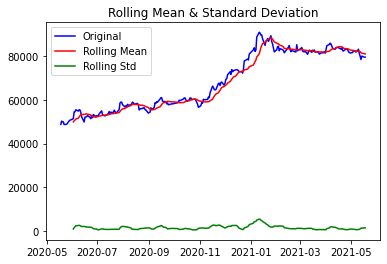

In [6]:
plot_rolling_statistics(ts)

차트가 우상향으로 아주 좋은 모습을 보이고 있다. (떡상 가즈아~)   
하지만 시간의 변화에 따라 평균과 분산이 증가해 시계열이 안정적이지 않다고 할 수 있기 때문에 **로그변환**을 해주도록한다

In [7]:
# 로그 변환
ts_log = np.log(ts)

In [8]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드 호출
    dftest = adfuller(timeseries, autolag="AIC")
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print("Results of Dickey-Fuller Test:")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

위 함수는 안정성 여부 체크하는 통계적 방법으로 귀무가설과 대립가설을 사용한다.  
간단하게만 하면 `p-value`값이 중요하며 귀무가설이 틀린 확률이라고 볼 수도 있다.   
p-value가 0.05 이상이면 귀무가설 대신 대립가설을 채택할 근거가 된다


## 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

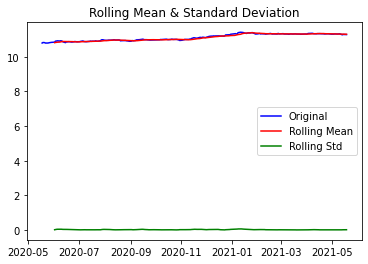

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


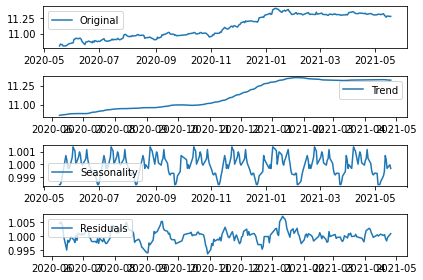

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

`Residual` = `Original` 데이터에서 `Trend`, `Seasonality` 제거하고 난 나머지

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True) # 결측치 제거
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


p-value가 매우 낮은 점수로 안정성이 있다고 할 수 있다

## 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리
- 분리 비율은 9:1로 한다

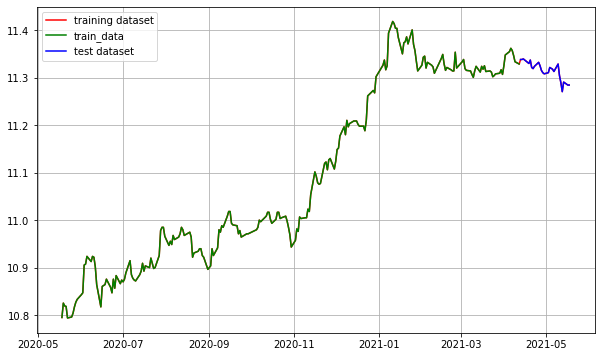

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(train_data, c='g', label='train_data')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

궁금해져서 train_data와 ts_log 데이터를 둘다 출력 빨간색 부분이 ts_log 그래프와 test_data가 연결되는 부분   
확실히 train_data와 test_data는 떨어져 보이긴 한다

## 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 : p, q 구하기
- 차분 안정성 확인 : d 구하기

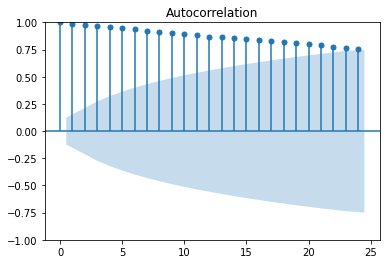

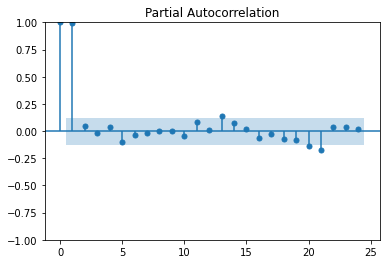

In [12]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF를 보면 앞의 실습과 동일하게 p > 2 일때는 0에 가까워지기 대문에 `p=1`이 적합하다고 할 수 있다   
ACF는 점차 감소하고 있어 `q=0`으로 둔다

d를 구하기 위해 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


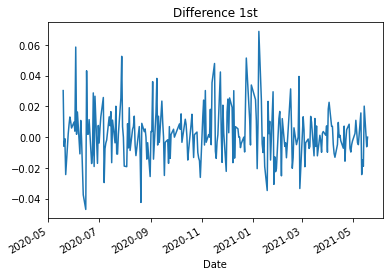

In [13]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [14]:
# # 필요할 때 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

1차 차분만으로 p-value가 낮은 안정된 상태임을 확인할 수 있으므로 2차 차분은 하지 않는다



## ARIMA 모델 훈련과 테스트 

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [15]:
# 모델 빌드하기
model = ARIMA(train_data, order=(2, 0, 1)) # order=c(p,d,q) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        09:45:28   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

In [16]:
# # 모델 훈련 결과 시각적으로 확인

# fitted_m = fitted_m.predict()
# fitted_m = fitted_m.drop(fitted_m.index[0])
# plt.figure(figsize=(20, 5))
# plt.plot(fitted_m, label='predict')
# plt.plot(train_data, label='train_data')
# plt.legend()

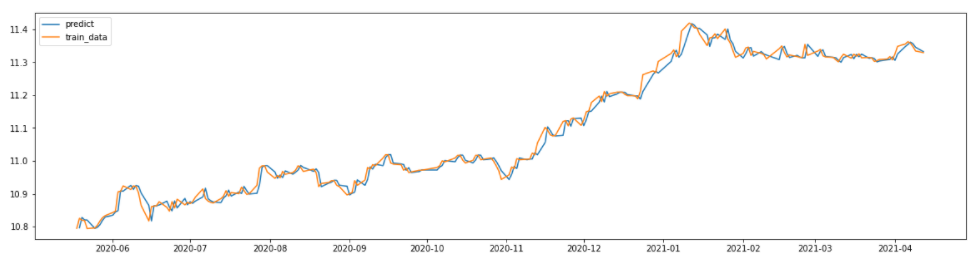   
완벽하진 않지만 나름 잘 예측한 것을 확인할 수 있다.


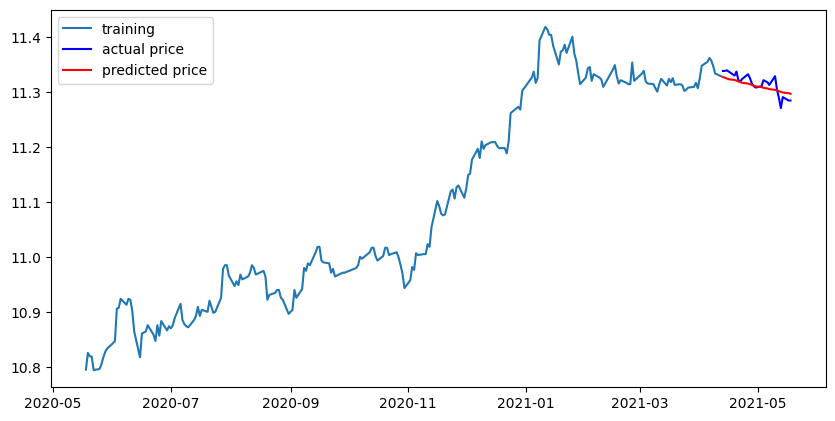

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


## 회고
이번 익스는 아주 재미있게 진행했다. 돈 버는것을 싫어하는 사람이 없듯이 아마 나뿐만 아니라 모든 사람이 이 노드를 보고 눈을 번쩍이지 않았을까?   

이번 진행과정은 이론도 크게 어렵지 않고 전체적으로 이해도가 높은 상태에서 빨리 진행할 수 있었다.  
이번 결과값을 보면서 생각한 것은 왜 디테일한 파동이 나오지 않을까였다.  
그래서 생각한게 이 데이터는 일봉 데이터기 때문에 60분봉이나 240분봉 데이터 분석을 진행하면 좀 더 디테일한 값이 나오지 않을까 생각했지만 아쉽게도 Yahoo.finance에는 일, 주, 월 데이터만 지원해서 아쉬움이 남았다.   
하지만 다음에 다른 데이터를 구할 수 있다면 시간봉도 가지고 한번 예측을 진행하는 과정을 해보고 싶다. 

### 다른 종목 실습
다른 종목 예측을 한번 진행해보고 싶어서 이것저것 여러 종목을 실습해보고 다른 방향으로 Apple주식의 일, 주, 월 데이터를 가지고도 실습해봤다.   

우선 다른 종목의 경우 Apple, SONY, Amazon 이 세가지를 더 진행해봤다   

#### SONY
SONY의 경우 딱 테스트 데이터 부분은 떡락구간이였는데 어느 정도 떡락을 예측했다. 
솔직히 말하면 급락폭을 충분히 예측했다고 할 수는 없지만 그래도 하락을 예상했다는 것은 나름 유의미한 결과라고 볼 수 도 있다
`MAPE의 값은 8.14%가 나왔다`

#### Amazon
아마존의 경우는 급락이후 다시 저항선까지 올라왔다 다시 떨어진 모습을 확인할 수 있다.   
예측 결과 값은 테스트 데이터의 처음과 끝을 생각하면 어느정도 맞다고 볼 수 있지만 솔직히 옳게 됐다고 볼 수는 없다
`MAPE : 7.95%`가 나왔지만 %만 가지고 잘 나왔다 괜찮다고 할 수는 없다
이 예측 값을 보고 투자를 한다면 낭패를 봤을게 뻔하기 때문이다.

> SONY, Amazon의 사진을 넣었었는데 에러가 나서 뺐습니다 다시 넣을려니 파일을 삭제해야해서 일단 보류를 했습니다

### Apple 일, 주, 월
따로따로 이야기하기 보다는 한번에 이야기 하자면 왜 그런지 모르겠지만 전체적으로 예측한 데이터의 모양이 같은 것을 알 수 있다.  
분명 일, 주, 월봉은 전부 다른데 왜 거의 비슷한 각도로 하방을 그리는지 모르겠다.

#### Apple 일봉 예측
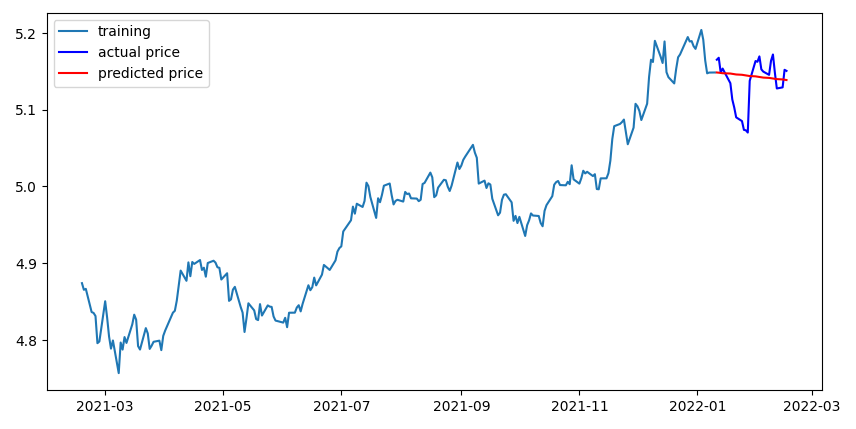   
#### Apple 주봉 예측
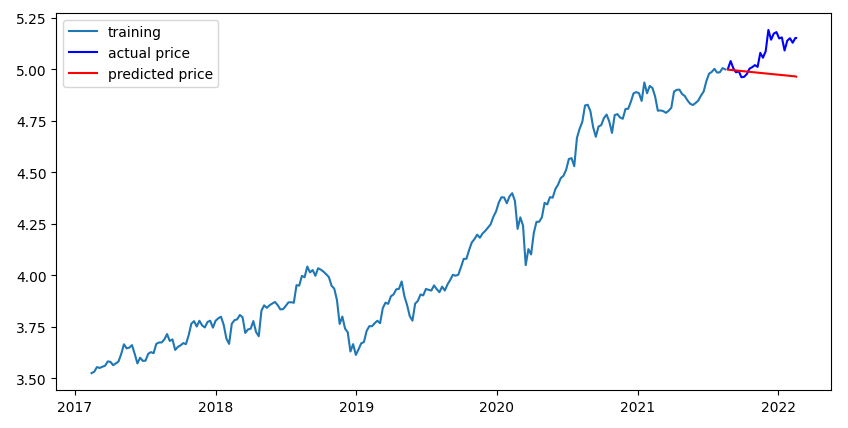   
#### Apple 월봉 예측
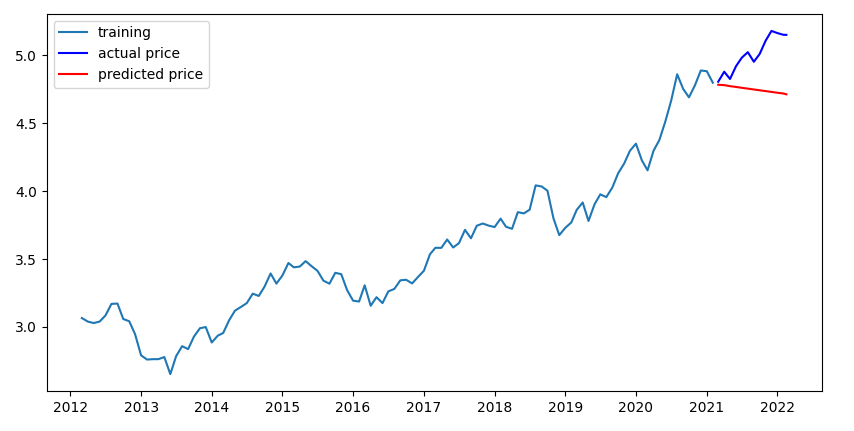

### 문제점
또한 몇 가지 문제가 있다
- 월봉에서 에러 발생
   - 1980년부터 현재까지 월봉 데이터를 예측해볼려고 했지만 에러가 발생했다
   - `ValueError: Multiplicative seasonality is not appropriate for zero and negative values`
   
- 전부 일정하다는 편향 오류
   - 지금 보면 삼성전자와 애플 둘다 문제점은 주식이 우상향이라는 것이다
   - 이는 상승추세에서는 문제가 없지만 만약 추세반전이 일어나 하락주세로 차트가 바뀌게 된다면 거기에 대한 데이터가 부족하기 때문에 잘못된 예측을 할 것임을 예상할 수 있다.
   
### 문제 해결 시도
첫 째로 일, 주, 월 전부 비슷한 모양을 보이고 있어 이를 해결하기 위해서 여러가지 시도를 해보았다   
그 중에 계속 일자로 나타나는 문제는 모델 빌드 단계에서 `model = ARIMA(data, (p,d,q))`에서 `p`값을 30 이상으로 주니까 일자가 아닌 굴곡이 생겼다

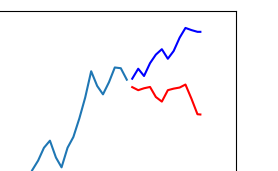 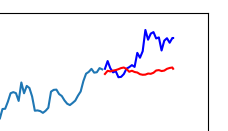

또한 월봉은 분기당 계산을 위해 `window=3`의 값을 주고, 주봉은 한달 계산을 위해 `window=4`의 값을 주기도 했지만  
의미없는 행동이였다 가장 근본적인 문제는 일봉이 문제없이 해결됐다고 주봉과 월봉도 똑같을 것이라고 생각하고 너무 대충 넘긴 실수였다.   

월봉과 주봉은 로그변환을 취해주더라고 안정적이지 못했다. 
#### 월봉
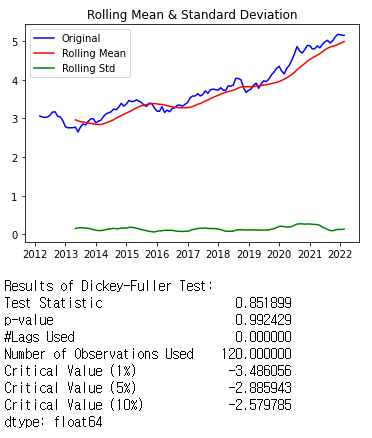
#### 주봉
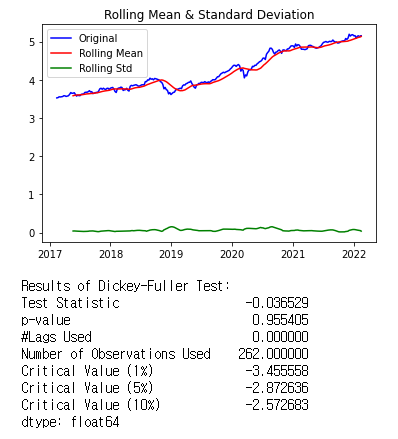

솔직하게 문제점을 해결하지 못했다. 로그변환으로도 해결되지 않는 데이터는 어떻게 해야할지 모르겠다

이 결과를 가지고 내릴 수 있는 결론은 지금 만든 예측 모델은 주, 월 같이 장기적인 예측은 불가능하기 때문에 장기투자 보다는 일봉으로 만든 데이터 예측을 통해 스윙이나 중장기 정도의 투자를 하는 것이 가장 적절할 것으로 사료된다.


참고 : apple 일, 주, 월 실습 파일은 같이 깃허브에 올려놨습니다.